In [314]:
import os
import cv2
import numpy as np
from PIL import Image
from collections import Counter
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
from sklearn.preprocessing import OneHotEncoder
#from skimage.feature import greycomatrix,greycoprops

In [315]:
data_path = r'C:\Users\mmatr\Desktop\Learning Data Science\IBM Machine Learning\Git\IBM-Machine-Learning-Course\Course_5_Deep_Learning\NEU Metal Surface Defects Data'
os.chdir(data_path)


In [316]:
def mse(a,b):
    """function to compute the mean square error between two numpy arrays"""
    return np.square(a-b).mean()

def load_images(data_path):
    """Function to load images from NEU Dataset"""

    images=[] 
    labels=[] 

    for dirpath, dirnames, filenames in os.walk(data_path):
        for filename in filenames:
            defect=dirpath.split('\\')[-1] 
            if '.bmp' in filename:
                images.append(cv2.imread(os.path.join(dirpath,filename),0))
                labels.append(defect)

    images=np.asarray(images)
    labels=np.asarray(labels)

    return images, labels

In [219]:
#code to acquaint with cv2. from tutorial on geeksforgeeks

# # path
# path = data_path + r'\test\Crazing\Cr_1.bmp'
  
# # Reading an image in grayscale mode
# image = cv2.imread(path, 0)
  
# # Window name in which image is displayed
# window_name = 'image'
  
# # Using cv2.imshow() method
# # Displaying the image
# cv2.imshow(window_name, image)
  
# # waits for user to press any key
# # (this is necessary to avoid Python kernel form crashing)
# cv2.waitKey(0)
  
# # closing all open windows
# cv2.destroyAllWindows()

I anticipate reuse of the following function to use the Train/Test/Validation Splits provided in the dataset.
However, as these splits are unbalanced (1656/72/72),constructing a larger test set may be appropriate.


I will proceed by loading all of the data into a single dataset and using a 15% test train split.


In [278]:
#load the data.
data, labels = load_images(data_path)

# train_images, train_labels = load_images(data_path + r'\train')
# val_images, val_labels = load_images(data_path + r'\valid')
# test_images, test_labels = load_images(data_path + r'\test')

In [279]:
#ensure labels came in correctly 
Counter(labels)


Counter({'Crazing': 300,
         'Inclusion': 300,
         'Patches': 300,
         'Pitted': 300,
         'Rolled': 300,
         'Scratches': 300})

In [280]:
l1=labels[labels=='Crazing']
l2=labels[labels=='Inclusion']
d1=list(data[labels=='Crazing'])
d2=list(data[labels=='Inclusion'])

for i in d2:
    d1.append(i)

    
data=np.asarray(d1)
labels=np.append(l1,l2)

# Context

Gray Scale intensities range from 0-255. 

The baseline classifier for this project is simply a comparison of contrast distribution in each image.  Normalized pixel intensity for each class will be calculated and displayed on a connected scatter plot.  Then, the mean square error (MSE) of each image with respect to the normalized intensity for each class will be computed.  The class the yields the lowest MSE will be the prediction for that image. 

Limitation of this analysis include:

Image quality. Even among images in the same class, background intensities vary significantly.  The images do not appear to be collected in a standardized manner.  

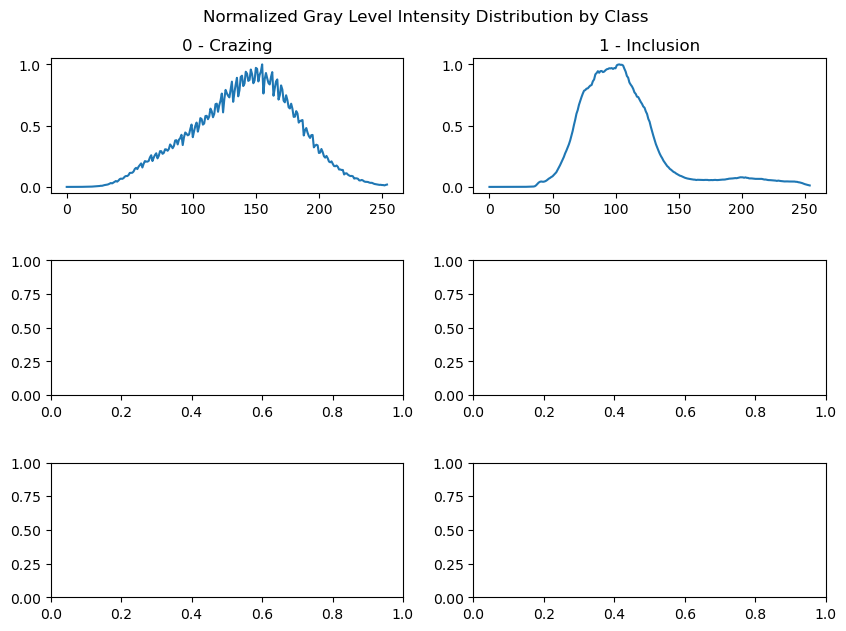

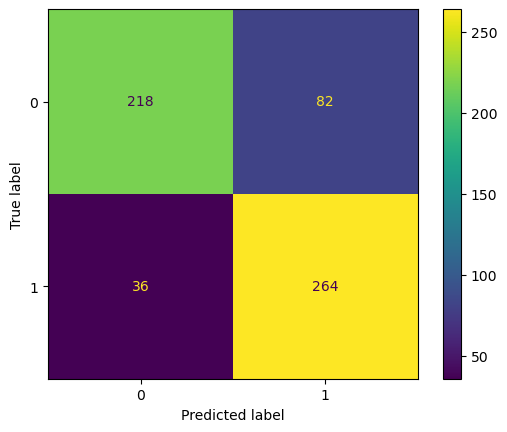

number of correct predictions =  482
total samples =  600
accuracy =  0.803


In [281]:
fig, axs = plt.subplots(3, 2, figsize=(10,7))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Normalized Gray Level Intensity Distribution by Class", fontsize=12, y=0.95)

hists=[]
for i, (case,ax) in enumerate(zip(np.unique(labels), axs.ravel())):
    #print(case)
    hist=np.zeros((256,1))

    cr = labels[labels==case]
    crd = data[labels==case]

    for image in crd:
        hist += cv2.calcHist([image],[0],None,[256],[0,256])
    
    lb=0
    ub=-1
    hist=hist[lb:ub]  
    index=hist.shape

    ax.plot(hist/max(hist))
    ax.set_title(str(i) + " - " + case)
    hists.append(hist/max(hist))
    
correct=0
count=0
true=[]
prediction=[]
for i,case in enumerate(np.unique(labels)):

    cr = labels[labels==case]
    crd = data[labels==case]
    

    for image in crd:
        hist = cv2.calcHist([image],[0],None,[256],[0,256])
        hist = hist[lb:ub]
        histn=hist/max(hist)
        
        msarray=np.array([mse(histn.ravel(), histavg.ravel()) for histavg in hists])
        
        pred=np.argmin(msarray)
                

        if pred == i:
            correct+=1

        true.append(i)
        prediction.append(pred)


    
conmat = confusion_matrix(true,prediction)
disp = ConfusionMatrixDisplay(conmat)
disp.plot()
plt.show()

print("number of correct predictions = ", correct)
print("total samples = ", len(data))
print("accuracy = ", round(accuracy_score(true,prediction),3))

In [282]:
#this code was used for determining which two classes were the most different

# storage=[]
# index=[]
# for i, dist in enumerate(hists):
#     if i<len(hists):
#         for j,dist2 in enumerate(hists[i+1:]):
#             index.append((i,j+i+1))
#             storage.append(mse(dist,dist2))
          
        
        
# ind=index[max(enumerate(storage), key=lambda x: x[1])[0]] 

# pitted=np.unique(labels)[ind[0]]
# scratch=np.unique(labels)[ind[1]]

# l = [v for i,v in enumerate(labels) if labels[i]==pitted or labels[i] == scratch]
# d = [v for i,v in enumerate(data) if labels[i]==pitted or labels[i] == scratch]

I drastically underestimated the complexity of this classification problem.  I will convert the dataset into a binary classification for the purposes of this exercise.  I will select the two classes whose normalized values are the least alike.  To find this, the MSE is computed between each case.

The following cell uses a train test split so that the predictor has new data to be tested against

In [283]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.33)

In [284]:
hists=[]
# The first loop calculates the pixel intensity distribution for each class
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.33)
for case in np.unique(labels):
    
    hist=np.zeros((256,1))

    cr = y_train[y_train==case]
    crd = X_train[y_train==case]

    for image in crd:
        hist += cv2.calcHist([image],[0],None,[256],[0,256])

    lb=0
    ub=-1
    hist=hist[lb:ub]   

    hists.append(hist/max(hist))

correct=0
true=[]
prediction=[]

# The second loop calculates the pixel intensity distribution for each image and calculates
# the mse wrt each class.
for ii, case in enumerate(np.unique(labels)):

    cr = y_test[y_test==case]
    crd = X_test[y_test==case]


    for image in crd:
        hist = cv2.calcHist([image],[0],None,[256],[0,256])
        hist=hist[lb:ub]
        histn=hist/max(hist)

        msarray=np.array([mse(histn.ravel(), histavg.ravel()) for histavg in hists])

        pred=np.argmin(msarray)


        if pred == ii:
            correct+=1

        true.append(ii)
        prediction.append(pred)
        
print("number of correct predictions = ", correct)
print("total samples = ", len(y_test))
print("accuracy = ", round(accuracy_score(true,prediction),3))


number of correct predictions =  158
total samples =  198
accuracy =  0.798


# Experiment 

The following code was implemented to run the classifier 1000 times to plot the accuracy distribution.  The CLT should hold meaning the distribution should be approximately normal.  The code is commented out because it takes a while to run and was purely for my own curiosity. 
 

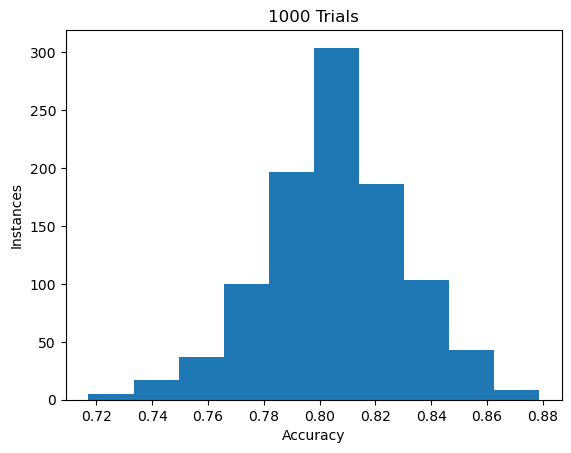

In [285]:
# accuracy=[]


# for jj in range(1000):
#     X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.33)
#     hists=[]
#     for case in np.unique(labels):
#         #print(case)
#         hist=np.zeros((256,1))

#         cr = y_train[y_train==case]
#         crd = X_train[y_train==case]

#         for image in crd:
#             hist += cv2.calcHist([image],[0],None,[256],[0,256])

#         lb=0
#         ub=-1
#         hist=hist[lb:ub]      

#         hists.append(hist/max(hist))

#     correct=0
#     count=0
#     true=[]
#     prediction=[]
#     for ii,case in enumerate(np.unique(labels)):

#         cr = y_test[y_test==case]
#         crd = X_test[y_test==case]


#         for image in crd:
#             hist = cv2.calcHist([image],[0],None,[256],[0,256])
#             hist=hist[lb:ub] 
#             histn=hist/max(hist)

#             msarray=np.array([mse(histn.ravel(), histavg.ravel()) for histavg in hists])

#             pred=np.argmin(msarray)


#             if pred == ii:
#                 correct+=1

#             true.append(ii)
#             prediction.append(pred)




#     accuracy.append(accuracy_score(true,prediction))

# plt.hist(accuracy)
# plt.xlabel('Accuracy')
# plt.ylabel('Instances')
# plt.title('1000 Trials')
# plt.show()


The results from the above cell are shown here:




# Begin Neural Network Model

In [286]:
import keras

#from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
#from tensorflow.keras.layers import Conv2D, MaxPooling2D

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from sklearn.preprocessing import LabelEncoder

Using TensorFlow backend.


In [298]:
#for development only.  The data is loaded in the top part of the notebook
data, labels = load_images(data_path)

l1=labels[labels=='Crazing']
l2=labels[labels=='Inclusion']
d1=list(data[labels=='Crazing'])
d2=list(data[labels=='Inclusion'])

for i in d2:
    d1.append(i)

    
data=np.asarray(d1)
labels=np.append(l1,l2)

ERROR! Session/line number was not unique in database. History logging moved to new session 538


In [299]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.33)

In [300]:
#this is necessary to get the data into the form that keras likes.
le = LabelEncoder()

In [301]:
y_train = keras.utils.to_categorical(le.fit_transform(y_train).reshape(-1,1), 2)
y_test =  keras.utils.to_categorical(le.transform(y_test).reshape(-1,1), 2)

In [302]:
X_train.shape

(402, 200, 200)

In [303]:
X_train = X_train.reshape(len(X_train),200,200,1)
X_test = X_test.reshape(len(X_test),200,200,1)

In [311]:
input_shape=(200,200,1) #200x200 pixels.  1 color channel

model_1 = Sequential()

model_1.add(Conv2D(16, (3, 3), strides = (1, 1), padding='same',
                 input_shape=input_shape))

model_1.add(Activation('relu'))

model_1.add(Conv2D(16, (3, 3), strides = (1,1)))
model_1.add(Activation('relu'))

model_1.add(MaxPooling2D(pool_size=(3, 3)))


## Flatten turns 3x3x32 into 288x1
model_1.add(Flatten())
model_1.add(Dense(64))
model_1.add(Activation('relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(2))
model_1.add(Activation('softmax'))

model_1.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 200, 200, 16)      160       
_________________________________________________________________
activation_17 (Activation)   (None, 200, 200, 16)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 198, 198, 16)      2320      
_________________________________________________________________
activation_18 (Activation)   (None, 198, 198, 16)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 66, 66, 16)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 69696)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)               

In [312]:
batch_size = 32

# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(lr=0.0005, decay=1e-6)

# Let's train the model using RMSprop
model_1.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

model_1.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=15,
              validation_data=(X_test, y_test),
              shuffle=True)

Train on 402 samples, validate on 198 samples
Epoch 1/15
402/402 [==============================] - 7s 18ms/step - loss: 89.4612 - accuracy: 0.6940 - val_loss: 0.1808 - val_accuracy: 0.9343
Epoch 2/15
402/402 [==============================] - 7s 18ms/step - loss: 1.0620 - accuracy: 0.9652 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/15
402/402 [==============================] - 8s 20ms/step - loss: 0.3600 - accuracy: 0.9950 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/15
402/402 [==============================] - 12s 30ms/step - loss: 0.0368 - accuracy: 0.9900 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/15
402/402 [==============================] - 11s 28ms/step - loss: 0.0306 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/15
402/402 [==============================] - 11s 28ms/step - loss: 0.0472 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/15
402/402 [==============================] - 11s 28ms/step - lo

In [313]:
model_1.predict_classes(X_test)

y_test

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.

In [ ]:
input_shape=(200,200,1) #200x200 pixels.  1 color channel

model_2 = Sequential()

model_2.add(Conv2D(1, (3, 3), strides = (2, 2), padding='same',
                 input_shape=input_shape))

model_2.add(Activation('relu'))

model_2.add(Conv2D(1, (3, 3), strides = (2,2)))
model_2.add(Activation('relu'))

model_2.add(MaxPooling2D(pool_size=(3, 3)))


## Flatten turns 3x3x32 into 288x1
model_2.add(Flatten())
model_2.add(Dense(256))
model_2.add(Activation('relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(6))
model_2.add(Activation('softmax'))

model_2.summary()

In [ ]:
batch_size = 32

# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(lr=0.0005, decay=1e-6)

# Let's train the model using RMSprop
model_2.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

model_2.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=15,
              validation_data=(X_test, y_test),
              shuffle=True)

In [ ]:
model_2.predict_classes(X_test)

In [ ]:
input_shape=(200,200,1) #200x200 pixels.  1 color channel

model_3 = Sequential()

model_3.add(Conv2D(100, (5, 5), strides = (2, 2), padding='same',
                 input_shape=input_shape))

model_3.add(Activation('relu'))

model_3.add(Conv2D(99, (5, 5), strides = (3,3)))
model_3.add(Activation('relu'))

model_3.add(MaxPooling2D(pool_size=(2, 2)))


## Flatten turns 3x3x32 into 288x1
model_3.add(Flatten())
model_3.add(Dense(256))
model_3.add(Activation('relu'))
model_3.add(Dropout(0.5))
model_3.add(Dense(6))
model_3.add(Activation('softmax'))

model_3.summary()

In [ ]:
batch_size = 32

# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(lr=0.0005, decay=1e-6)

# Let's train the model using RMSprop
model_3.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

model_3.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=15,
              validation_data=(X_test, y_test),
              shuffle=True)